# Load Model from Checkpoint

In [5]:
import os
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yaml

from mctm.data.sklearn_datasets import get_dataset
from mctm.models import DensityRegressionModel, HybridDenistyRegressionModel
from mctm.utils.visualisation import plot_samples

2023-09-20 17:24:52.369967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-20 17:24:52.369985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Params

In [6]:
params_file_path = "../params.yaml"
results_path = "../results"

In [7]:
!ls $results_path/bernstein_flow/mcp

ls: cannot access '../results/bernstein_flow/mcp': No such file or directory


In [8]:
with open(params_file_path) as params_file:
    params = yaml.safe_load(params_file)

# Load Data

In [9]:
# generate data
dataset = "moons"
# dataset = "circles"
(X, Y), dims = get_dataset(dataset, **params["datasets"][dataset])

# Utility functions

In [10]:
def load_models(dims, stage_name, dataset, results_path=None, **kwds):
    models = {}
    for name, d in deepcopy(params)[f"{stage_name}_distributions"].items():
        model_kwds = d[dataset].copy()
        model_kwds["distribution_kwds"].update(**kwds)
        model_kwds.pop("fit_kwds")
        print(model_kwds)
        if "base_distribution" in model_kwds.keys():
            get_model = HybridDenistyRegressionModel
        else:
            get_model = DensityRegressionModel
        models[name] = get_model(dims=dims, distribution=name, **model_kwds)
        if results_path is not None:
            cp_path = os.path.join(
                results_path, "_".join((stage_name, name, dataset)), "mcp/weights"
            )

            if os.path.exists(cp_path + ".index"):
                print("Loading weights for ", name)
                models[name].load_weights(cp_path)
        return models

# Plot samples

## unconditional

In [8]:
stage_name = "unconditional"

In [9]:
models = load_models(dims, stage_name, dataset, results_path)

Loading weights for  bernstein_flow


2023-09-12 14:29:27.709039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-12 14:29:27.709074: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-12 14:29:27.709107: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux.fritz.box): /proc/driver/nvidia/version does not exist


bernstein_flow sampling took 0.2609734535217285 seconds.


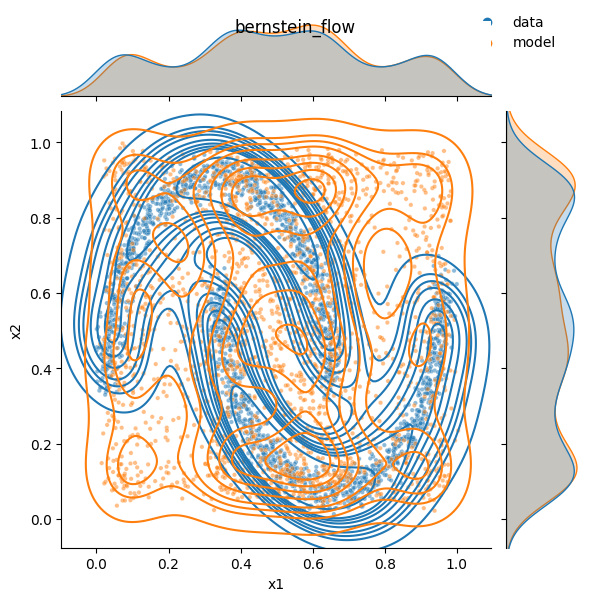

In [10]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_samples(model(X), X, seed=1)
    fig.suptitle(name)

## conditional

In [11]:
stage_name = "conditional"

In [12]:
models = load_models(dims, stage_name, dataset, results_path)

Loading weights for  bernstein_flow


bernstein_flow sampling took 0.19816160202026367 seconds.


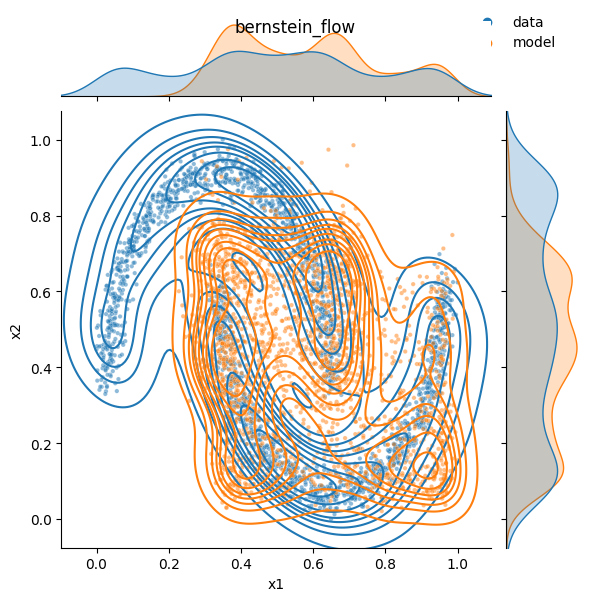

In [13]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_samples(
        model(tf.convert_to_tensor(Y[..., None], dtype=model.dtype)), X, seed=1
    )
    fig.suptitle(name)

## unconditional hybrid

In [22]:
stage_name = "unconditional_hybrid"

In [23]:
models = load_models(dims, stage_name, dataset, results_path)

{'distribution_kwds': {'order': 100, 'low': 0, 'high': 1, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'shift': False, 'scale': False, 'clip_to_bernstein_domain': False, 'coupling_layers': 1}, 'freeze_base_model': False, 'base_checkpoint_path': False, 'parameter_kwds': {'hidden_units': [16, 16], 'activation': 'relu', 'batch_norm': False}, 'base_distribution': 'bernstein_flow', 'base_distribution_kwds': {'order': 50, 'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'shift': False, 'scale': False, 'clip_to_bernstein_domain': False}, 'base_parameter_kwds': {'conditional': False, 'dtype': 'float32'}, 'fit_kwds': {'epochs': 10000, 'validation_split': 0.1, 'batch_size': 512, 'learning_rate': 0.01, 'lr_patience': 500, 'reduce_lr_on_plateau': True, 'early_stopping': True, 'verbose': True, 'monitor': 'val_loss'}}
Loading weights for  coupling_bernstein_flow


coupling_bernstein_flow uneven number of coupling layers -> skipping last permutation
sampling took 0.5232889652252197 seconds.


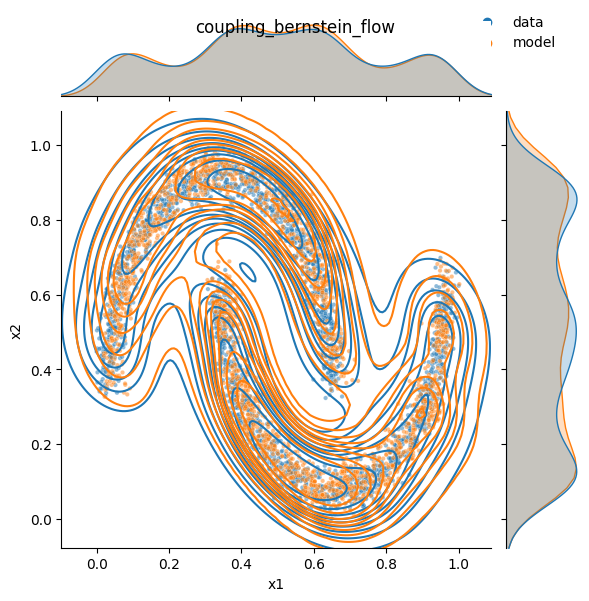

In [24]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_samples(
        model(tf.convert_to_tensor(Y[..., None], dtype=model.dtype)), X, seed=1
    )
    fig.suptitle(name)

In [25]:
from mctm.utils.visualisation import plot_flow

coupling_bernstein_flow uneven number of coupling layers -> skipping last permutation


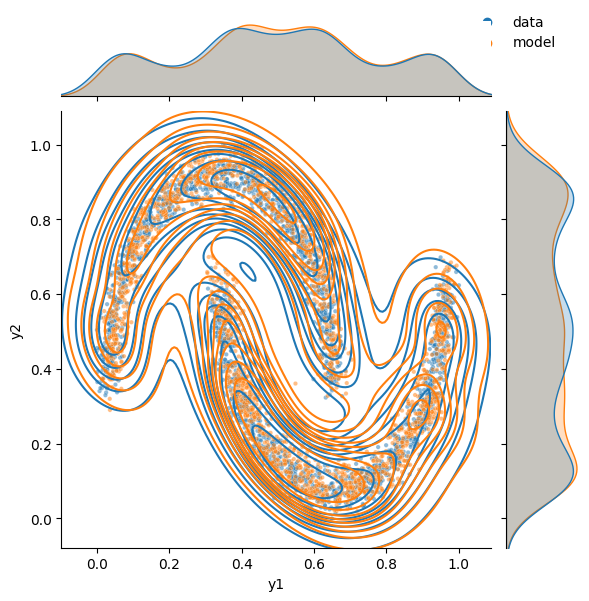

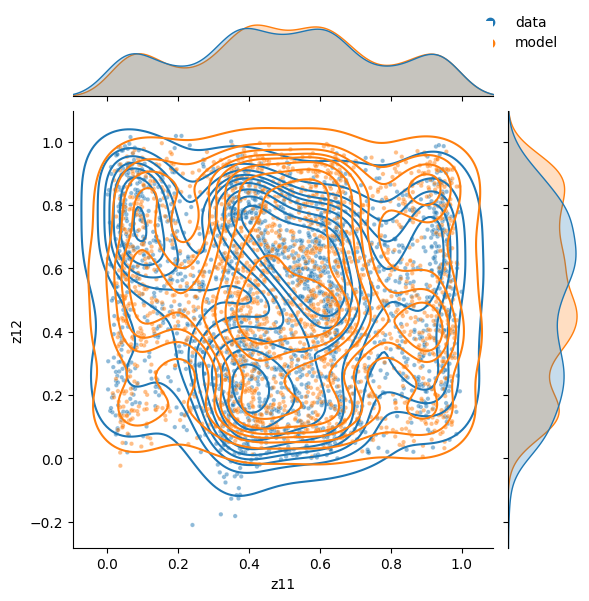

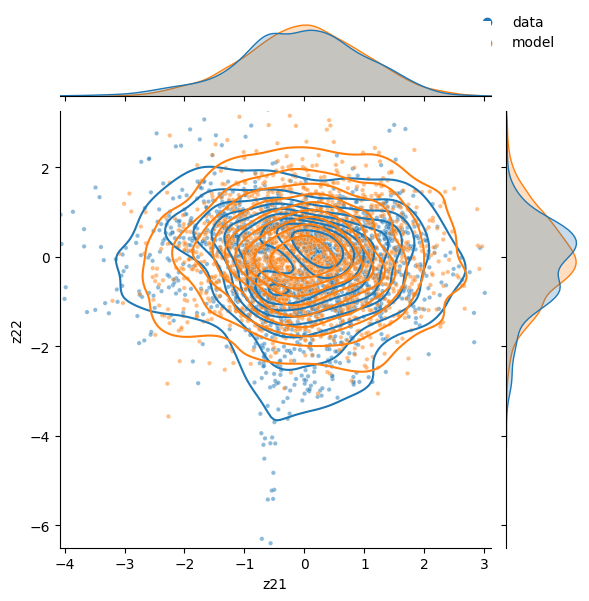

In [26]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_flow(
        model(tf.convert_to_tensor(Y[..., None], dtype=model.dtype)), Y, X, seed=1
    )
    # fig.suptitle(name)

In [201]:
model = models["coupling_bernstein_flow"]
dist = model.distribution_lambda(model.distribution_parameters_lambda(Y))

uneven number of coupling layers -> skipping last permutation


## unconditional hybrid pre trained

In [30]:
stage_name = "unconditional_hybrid_pre_trained"

In [31]:
models = load_models(stage_name, dataset, results_path)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for unconditional_bernstein_flow

In [51]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_flow(
        model(tf.convert_to_tensor(Y[..., None], dtype=model.dtype)), Y, X, seed=1
    )
    # fig.suptitle(name)

Loading weights for  coupling_bernstein_flow


## unconditional Benchmark

In [43]:
stage_name = "unconditional_benchmark"
benchmark_ds = "BSDS300"

In [44]:
from mctm.data.benchmark import get_dataset

In [45]:
(train, val, test), dims = get_dataset(benchmark_ds, "../datasets/")

In [46]:
train_sub = train[:10000]
train_sub.min(), train_sub.max()

(-0.7767895, 0.7636229)

In [47]:
from tensorflow_probability import bijectors as tfb

In [48]:
scale=params["benchmark_datasets"][benchmark_ds]["scale"]
shift=params["benchmark_datasets"][benchmark_ds]["shift"]
chain=tfb.Invert(tfb.Chain([
    tfb.Scale(tf.convert_to_tensor(scale)),
    tfb.Shift(tf.convert_to_tensor(shift)),
]))

In [49]:
train_std=chain.inverse(train_sub).numpy()
train_std.min(), train_std.max()

(0.0076964456, 1.0)

In [50]:
models = load_models(
    dims,
    stage_name,
    benchmark_ds,
    scale=scale,
    shift=shift,
)

{'distribution_kwds': {'order': 100, 'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'shift': [0.858957827091217, 0.8417633175849915, 0.8207302689552307, 0.8167888522148132, 0.8271582126617432, 0.8002507090568542, 0.8622584939002991, 0.9036107063293457, 0.8724204301834106, 0.8366307020187378, 0.7527638077735901, 0.7614379525184631, 0.7945226430892944, 0.7900691032409668, 0.7851378917694092, 0.8411343693733215, 0.810021162033081, 0.7124636173248291, 0.786227285861969, 0.875061571598053, 0.7579098343849182, 0.7953081727027893, 0.7829033136367798, 0.8367931246757507, 0.7648852467536926, 0.7432070374488831, 0.7520200610160828, 0.7791620492935181, 0.7826623916625977, 0.7129452228546143, 0.8394992351531982, 0.8043412566184998, 0.8052926659584045, 0.7797779440879822, 0.7612169981002808, 0.8703255653381348, 0.836017906665802, 0.7697322964668274, 0.7665404677391052, 0.8299756646156311, 0.7607430815696716, 0.7876516580581665, 0.8117465972900391, 0.8365708589553833, 0.

In [ ]:
dist = models["bernstein_flow"](None)
dist

<tfp.distributions._TransformedDistribution 'invert_chain_of_bpoly_of_f1_scale_of_f1_shiftSampleNormal' batch_shape=[1] event_shape=[6] dtype=float32>

In [21]:
train_std = (train_sub - shift) * scale
train_std.min(), train_std.max()

(-0.9997859552279311, 0.533315177457166)

In [38]:
f1_shift=dist.bijector.bijector.bijectors[-1]
f1_scale=dist.bijector.bijector.bijectors[-2]
f1_shift, f1_scale

(<tfp.bijectors.Shift 'f1_shift' batch_shape=[1, 6] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>,
 <tfp.bijectors.Scale 'f1_scale' batch_shape=[1, 6] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>)

In [39]:
train_std = f1_shift.inverse(train_sub).numpy()
train_std.min(), train_std.max()

(1.1205673e-05, 8.213183)

In [41]:
train_std = f1_scale(train_std).numpy()
train_std.min(), train_std.max()

(1.1205673e-05, 8.213183)

In [28]:
dist.bijector(train[:100])

<tf.Tensor: shape=(100, 6), dtype=float32, numpy=
array([[ 7.503832 ,  9.764326 ,  6.8667097,  8.281471 ,  3.6356826,
         3.202514 ],
       [ 5.7234907, 12.654505 ,  6.6519346,  8.706631 ,  2.5567772,
         4.3360467],
       [ 6.128604 ,  9.606335 ,  6.6700444,  8.583599 ,  2.6347027,
         3.8544745],
       [ 5.5655603,  7.836657 ,  6.7952995,  8.212804 ,  2.587942 ,
         2.95148  ],
       [ 7.300275 , 11.892922 ,  6.6115413,  8.364939 ,  3.6626692,
         2.7973733],
       [ 5.5717134, 10.509077 ,  6.7980976,  8.652698 ,  2.5645247,
         3.8177495],
       [ 5.4228926, 12.188904 ,  6.6817203,  8.281808 ,  2.6865513,
         3.9240546],
       [ 8.524837 ,  9.239107 ,  6.8870883,  8.307915 ,  4.18849  ,
         4.0035295],
       [ 5.9107304, 13.926601 ,  6.812709 ,  8.714752 ,  2.5887384,
         3.7081633],
       [ 8.014175 , 12.526152 ,  6.8411713,  8.194667 ,  3.7135923,
         4.2648826],
       [ 6.337555 , 10.892151 ,  7.133279 ,  8.342525 ,  2.6

In [27]:
for name, model in models.items():
    print(name, end=" ")
    fig = plot_samples(
        model(tf.convert_to_tensor(Y[..., None], dtype=model.dtype)), X, seed=1
    )
    fig.suptitle(name)

bernstein_flow sampling took 0.25306057929992676 seconds.


ValueError: Shape of passed values is (2000, 6), indices imply (2000, 2)

# DBG Scale and shift

In [7]:
{
    "distribution_kwds": {
        "order": 50,
        "low": -3,
        "high": 3,
        "smooth_bounds": True,
        "allow_flexible_bounds": True,
        "shift": False,
        "scale": False,
        "clip_to_bernstein_domain": False,
        "coupling_layers": 2,
    },
    "parameter_kwds": {
        "hidden_units": [16, 16],
        "activation": "relu",
        "batch_norm": False,
    },
    "fit_kwds": {
        "epochs": 10000,
        "validation_split": 0.1,
        "batch_size": 512,
        "learning_rate": 0.001,
        "lr_patience": 50,
        "reduce_lr_on_plateau": True,
        "early_stopping": True,
        "verbose": True,
        "monitor": "val_loss",
    },
}

{'distribution_kwds': {'order': 50,
  'low': -3,
  'high': 3,
  'smooth_bounds': True,
  'allow_flexible_bounds': True,
  'shift': False,
  'scale': False,
  'clip_to_bernstein_domain': False,
  'coupling_layers': 2},
 'parameter_kwds': {'hidden_units': [16, 16],
  'activation': 'relu',
  'batch_norm': False},
 'fit_kwds': {'epochs': 10000,
  'validation_split': 0.1,
  'batch_size': 512,
  'learning_rate': 0.001,
  'lr_patience': 50,
  'reduce_lr_on_plateau': True,
  'early_stopping': True,
  'verbose': True,
  'monitor': 'val_loss'}}

In [10]:
dims = 7
model = DensityRegressionModel(
    dims=dims,
    distribution="coupling_bernstein_flow",
    **{
        "distribution_kwds": {
            "order": 50,
            "low": -3,
            "high": 3,
            "smooth_bounds": True,
            "allow_flexible_bounds": True,
            "shift": [float(i) for i in range(dims)],
            "scale": [float(i) * 0.1 + 2 for i in range(dims)],
            "clip_to_bernstein_domain": False,
            "coupling_layers": 2,
        },
        "parameter_kwds": {
            "conditional": False,
            "hidden_units": [12, 3, 32],
            "activation": "relu",
            "batch_norm": False,
        },
    }
)
model(None)

{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d2823bdc0>
3 (1, 3, 50)
[3, 4, 5, 6, 0, 1, 2]
3
{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d99486550>
4 (1, 4, 50)
[4, 5, 6, 0, 1, 2, 3]
4


<tfp.distributions._TransformedDistribution 'chain_of_invert_f1_shift_of_invert_f1_scale_of_real_nvp_of_permute_of_real_nvp_of_permuteSampleNormal' batch_shape=[1] event_shape=[7] dtype=float32>

In [11]:
bijectors = model(None).bijector.bijectors
bijectors

{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d2823bdc0>
3 (1, 3, 50)
[3, 4, 5, 6, 0, 1, 2]
3
{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d99486550>
4 (1, 4, 50)
[4, 5, 6, 0, 1, 2, 3]
4


[<tfp.bijectors.Invert 'invert_f1_shift' batch_shape=[1, 7] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32 bijector=<tfp.bijectors.Shift 'f1_shift' batch_shape=[1, 7] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>>,
 <tfp.bijectors.Invert 'invert_f1_scale' batch_shape=[1, 7] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32 bijector=<tfp.bijectors.Scale 'f1_scale' batch_shape=[1, 7] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float32 dtype_y=float32>>,
 <tfp.bijectors.RealNVP 'real_nvp' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.RealNVP 'real_nvp' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>,
 <tfp.bijectors.Permute 'permute' batch_shape=[

In [12]:
model(None).log_prob(tf.ones((100, dims)))

{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d2823bdc0>
3 (1, 3, 50)
[3, 4, 5, 6, 0, 1, 2]
3
{'low': -3, 'high': 3, 'smooth_bounds': True, 'allow_flexible_bounds': True, 'clip_to_bernstein_domain': False, 'scale': False, 'shift': False} 7 <function get_simple_fully_connected_parameter_network_lambda.<locals>.parameter_network_lambda at 0x7f9d99486550>
4 (1, 4, 50)
[4, 5, 6, 0, 1, 2, 3]
4
(100, 3, 50) (100, 3)
(100, 3, 51)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100,4,51] vs. [100,3,51] [Op:Mul] name: 

In [13]:
from matplotlib import pyplot as plt

invert_f1_shift
(100, 7)
invert_f1_scale
(100, 7)
real_nvp
(100, 3, 50) (100, 3)
(100, 3, 51)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100,4,51] vs. [100,3,51] [Op:Mul] name: 

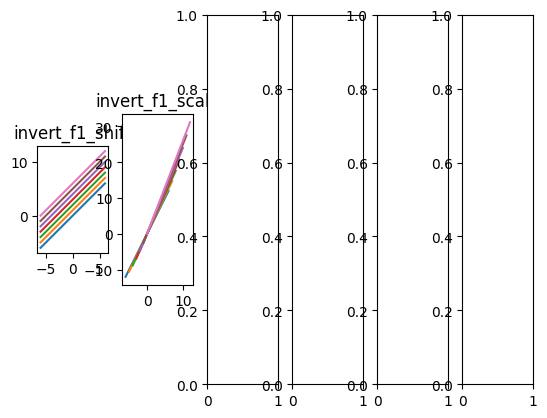

In [14]:
fig, ax = plt.subplots(1, len(bijectors))
y = tf.linspace(-6.0, 6.0, 100)
y = tf.reshape(tf.repeat(y, dims), (-1, dims))

for a, b in zip(ax, bijectors):
    print(b.name)
    z = b.inverse(y)
    print(z.shape)
    a.plot(y, z)
    a.set_title(b.name)
    a.set(aspect=1)
    y = z
fig.tight_layout()

In [16]:
b._num_masked

3

In [19]:
y[..., :3]

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[-12.        , -10.5       ,  -8.8       ],
       [-11.757576  , -10.245455  ,  -8.533334  ],
       [-11.515152  ,  -9.99091   ,  -8.266667  ],
       [-11.272727  ,  -9.736362  ,  -8.        ],
       [-11.030303  ,  -9.481817  ,  -7.7333336 ],
       [-10.787879  ,  -9.227273  ,  -7.466667  ],
       [-10.545454  ,  -8.972726  ,  -7.2       ],
       [-10.30303   ,  -8.718181  ,  -6.9333334 ],
       [-10.060606  ,  -8.463635  ,  -6.666667  ],
       [ -9.818182  ,  -8.209091  ,  -6.4       ],
       [ -9.575758  ,  -7.9545455 ,  -6.1333337 ],
       [ -9.333333  ,  -7.6999993 ,  -5.8666663 ],
       [ -9.090909  ,  -7.445454  ,  -5.6       ],
       [ -8.848485  ,  -7.190909  ,  -5.3333335 ],
       [ -8.60606   ,  -6.9363627 ,  -5.066666  ],
       [ -8.363636  ,  -6.6818175 ,  -4.7999997 ],
       [ -8.121212  ,  -6.4272723 ,  -4.5333333 ],
       [ -7.878788  ,  -6.172727  ,  -4.266667  ],
       [ -7.6363635 ,  -5.918181

In [18]:
b.forward(y)

(100, 3, 50) (100, 3)
(100, 3, 51)


InvalidArgumentError: {{function_node __wrapped__LessEqual_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [100,4] vs. [100,3] [Op:LessEqual] name: 

In [21]:
dims = 7

In [24]:
num_masked = dims // 2
num_masked

3

In [26]:
list(range(num_masked, dims)) + list(range(num_masked))

[3, 4, 5, 6, 0, 1, 2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 5.], dtype=float32)>

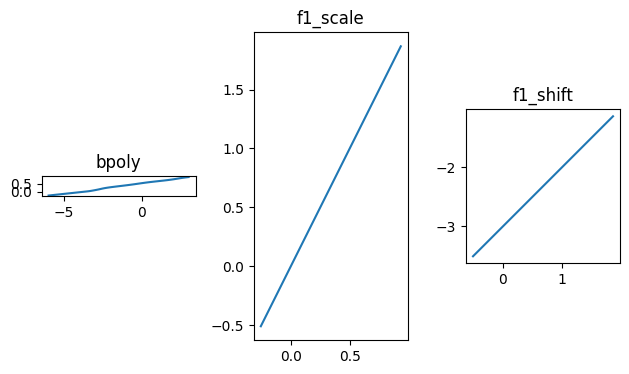

In [54]:
fig, ax = plt.subplots(1, len(bijectors))
for a, b in zip(ax, bijectors):
    z = b.inverse(y)
    a.plot(y, z)
    a.set_title(b.name)
    a.set(aspect=1)
    y = z
fig.tight_layout()

In [27]:
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate

In [33]:
thetas = tf.ones((1, 22, 51))
bpoly = BernsteinBijectorLinearExtrapolate(thetas)

In [34]:
bpoly.forward(tf.ones((1, 21)))

InvalidArgumentError: Incompatible shapes: [1,21,51] vs. [1,22,51] [Op:Mul]